<a href="https://colab.research.google.com/github/kankeinai/Research-assistance-Summer-2022/blob/main/RA_ship_Toy_Experiment_Denoise_Plunk_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rejection sampling

We would like to get a "difficult" (target) distribution. For this purposes we can use a rejection sampling which utilizes some "easy" (proposal) distribution (eg. gaussian or uniform) by discarding some of the samples.

In this Jupyter notebook, I am going to implement a generator of Planck function distribution, which has next formula: $$L(v,t)=\frac{2hv^3}{c^2}\frac{1}{e^{\frac{hv}{k_BT}}-1},$$
where $L(v,t)$ is black body radiance,  $h$ is planck constant, $c$ is speed of light, $k_B$ is Boltzman constant, $v$ is frequency and $t$ is black body temperature.

##Initial setup

In [1]:
import numpy as np
from scipy import stats
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import TensorDataset, DataLoader

In [2]:
h = 6.62606957e-34 #planck constant
c = 299792458 #speed of light
k_B = 1.3806488e-23 #boltzman constant

min_freq = 100
max_freq = 1.5e14

In [3]:
L = lambda v, t: (2*h*v**3)/c**2/(np.exp(h*v/(k_B*t))-1)

##Graphical visualization

At first, lets look at how function looks like. I will generate a heat map since our function $L(v,t)$ is 3-dimensional.

In [4]:
v = np.linspace(min_freq, max_freq, 1000)
t = np.linspace(100, 500, 1000)

In [5]:
X, Y = np.meshgrid(v, t)
Z = L(X, Y)

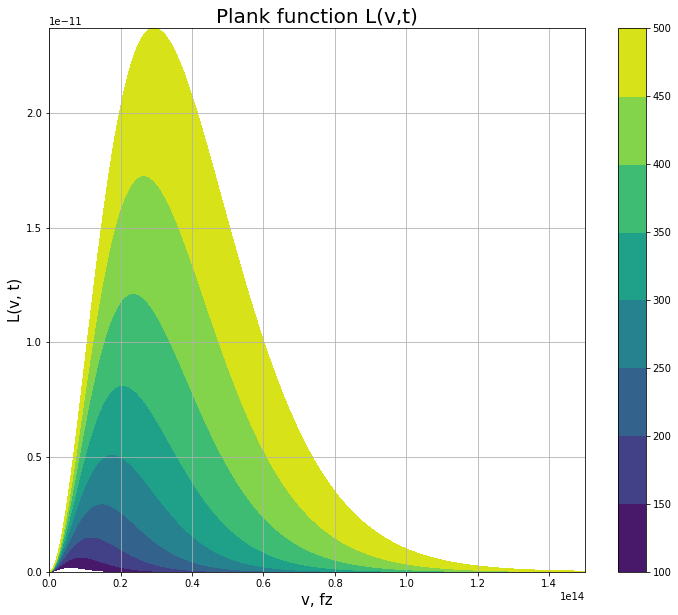

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
cp = ax.contourf(X, Z, Y)
fig.colorbar(cp) # Add a colorbar to a plot
  
#graph settings
ax.set_title('Plank function L(v,t)',fontsize=20)
ax.set_xlabel('v, fz',  fontsize=15)
ax.set_ylabel('L(v, t)',  fontsize=15)
plt.grid()
plt.show()

##Choosing proposal distribution

The main problem with rejection sampling is to choose proposal distribution. Right choice of proposed distribution gurantees less rejection rate.

To make things simpler, I will fix a temperature. 

As a proposal distribution, I have chosen uniform distribution, since the shape of the curve varies significantly with a different temperature. It may be challenging to define a formula for a constant $K$ to scale any other distribution so that it still fits any temperature.

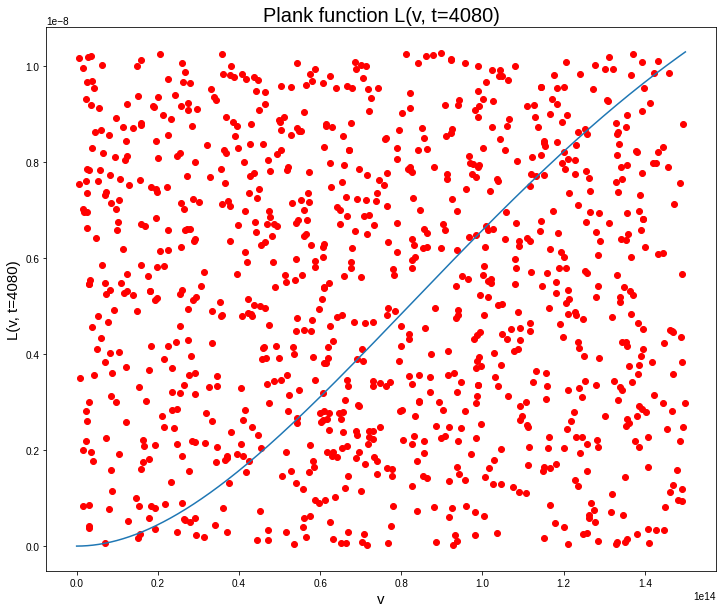

In [7]:
t_fixed = np.random.randint(100,5000)
Z_new = L(v, t_fixed)
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title(f'Plank function L(v, t={t_fixed})',fontsize=20)
ax.set_xlabel('v',  fontsize=15)
ax.set_ylabel(f'L(v, t={t_fixed})',  fontsize=15)
ax.plot(v, Z_new)

x = np.random.uniform(0, max_freq, 1000)
prop_uni = stats.uniform(0, max_freq)
K = max(L(x, t_fixed))/max(prop_uni.pdf(x))
u = np.random.uniform(0, K*prop_uni.pdf(x))
ax.scatter(x, u, color="red")
plt.style.use('seaborn-whitegrid')
plt.show()

##Creating a generator for planck function

In order to ensure that generator works correctly, I will also calculate expected acception rate.

In [8]:
def planck_generator(T, N, validation=False, max_n=10000):

    print(f"Planck function generator for T={T} and N={N}")
    x = np.random.uniform(min_freq, max_freq, max_n)
    prop_uni = stats.uniform(min_freq, max_freq)

    #I need to change formula a little bit for integratin purposes
    L = lambda v: (2*h*v**3)/c**2/(np.exp(h*v/(k_B*T))-1)

    #I need to identify scaling factor, so I need a maximum value of L(x)
    max_val = max(L(x))
 
    K = max_val/prop_uni.pdf(x[0])
    
    counter = 0
    
    #Expected acception rate is a ratio of areas under planck curve and 
    #are covered by uniform distribution
    #it will converge to experimental accception rate with increrasing number of samples
    uni_area = max_val * (max_freq-min_freq)
    planck_area = quad(L, min_freq, max_freq)[0]
    expected_rate = planck_area/uni_area
    
    #we need N samples, so search until found N acceptable samples
    generated = []

    while len(generated) < N:
        x = np.random.uniform(min_freq, max_freq)
        u = np.random.uniform(L(min_freq), K*prop_uni.pdf(x))
        val = L(x)
        if u<=val:
            generated.append(x)
        counter+=1
            
    acception_rate = len(generated)/counter

    if validation:
        print(f"Expected acception rate: {expected_rate},\nExperimental acception rate:{acception_rate}\n----------------")

    return np.array(generated), expected_rate, acception_rate


In [9]:
N=10000
t_fixed = np.random.randint(100,5000)

samples, expected_rate, experimental_acception_rate = planck_generator(t_fixed, N, True)

Planck function generator for T=494 and N=10000
Expected acception rate: 0.3134180880851634,
Experimental acception rate:0.31163326996790175
----------------


I would like to know how experimental acception rate varies with $N$

In [9]:
def plot_generated_planck_func(ax, color, t_fixed, N):
    Z_new = L(v, t_fixed)
    ax.set_title(f'Plank function L(v, t)',fontsize=20)
    ax.set_xlabel('v',  fontsize=15)
    ax.set_ylabel(f'L(v, t)',  fontsize=15)
    ax.plot(v, Z_new, label = f"T = {t_fixed} K", color=color)
    samples = planck_generator(t_fixed, N, True)[0]
    ax.scatter(samples, L(samples, t_fixed), color=color)
    plt.style.use('seaborn-whitegrid')
    

Planck function generator for T=995 and N=1000
Expected acception rate: 0.5904216081611244,
Experimental acception rate:0.5707762557077626
----------------
Planck function generator for T=942 and N=1000
Expected acception rate: 0.5680674958863625,
Experimental acception rate:0.5608524957936063
----------------
Planck function generator for T=933 and N=1000
Expected acception rate: 0.564048363510667,
Experimental acception rate:0.5724098454493417
----------------
Planck function generator for T=843 and N=1000
Expected acception rate: 0.5205069835855739,
Experimental acception rate:0.5219206680584552
----------------
Planck function generator for T=573 and N=1000
Expected acception rate: 0.36314301801387394,
Experimental acception rate:0.35385704175513094
----------------
Planck function generator for T=500 and N=1000
Expected acception rate: 0.317211447110823,
Experimental acception rate:0.315357931251971
----------------
Planck function generator for T=310 and N=1000
Expected acception

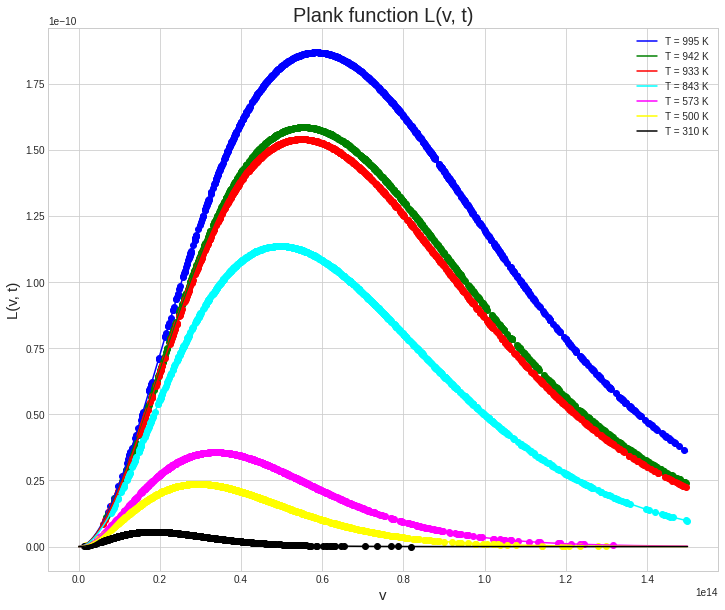

In [10]:
N = 1000
fig, ax = plt.subplots(figsize=(12, 10))
colors = ['blue','green',  'red', 'cyan', 'magenta', 'yellow', 'black']
T = np.random.randint(100, 1000, 7)
T.sort()

for color, t_fixed in zip(colors,T[::-1]):
    plot_generated_planck_func(ax, color, t_fixed, N)
    
plt.style.use('seaborn-whitegrid')   
ax.legend()
plt.show()

In this toy experiment we have an exact formula, but in future we will deal mostly with unsupervised learning. For a moment lets imagine that we don't have any formula for planck function, but the only thing that we posses are the frequences of observed particles.

Now, lets devide our range of frequencies into equidistant bins. 

In [11]:
def plot_plunck_function(num_bins, t_fixed, N):
    #generate data for graphs
    generated_samples = planck_generator(t_fixed, N, True)[0]
    true_samples = np.linspace(min_freq, max_freq, 1000)
    L_ch = lambda v: (2*h*v**3)/c**2/(np.exp(h*v/(k_B*t_fixed))-1)
    true_samples_L = L(v, t_fixed)/quad(L_ch, min_freq, max_freq)[0]


    #graph settings
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(f'Probability density',fontsize=20)
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    ax.set_xlabel('v',  fontsize=15)
    ax.set_ylabel(f'Probability',  fontsize=15)

    #plot graphs
    #n returns number of particles at each bin
    n, bins, patches = ax.hist(generated_samples, bins = num_bins, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5,  label="Generated v", density=True)

    #scale our L to this number of particles
    ax.plot(true_samples, true_samples_L, label = "Target v")

    max_val = max(n)
    plt.ylim(bottom=-max_val/3)
    plt.ylim(top=max_val*1.5)

    ax.legend()
    plt.show()

Planck function generator for T=1543 and N=10000
Expected acception rate: 0.6931443111027689,
Experimental acception rate:0.693000693000693
----------------


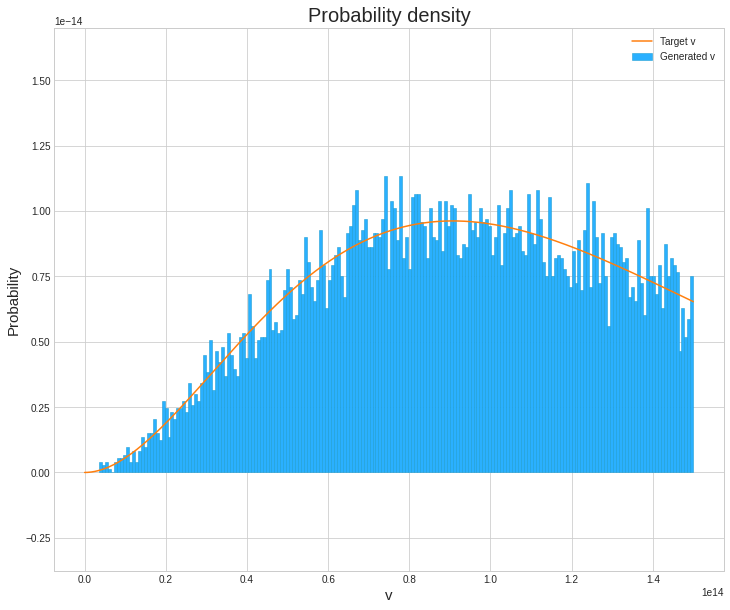

In [12]:
num_bins = 200
t_fixed = np.random.randint(1000, 5000)
N = 10000
plot_plunck_function(num_bins, t_fixed, N)

Planck function generator for T=4352 and N=100000
Expected acception rate: 0.4365996364639715,
Experimental acception rate:0.43762910058467247
----------------


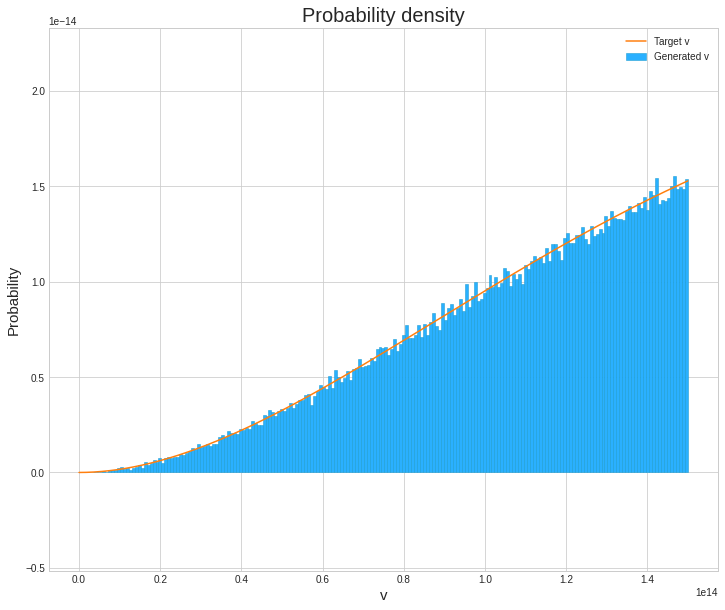

In [13]:
num_bins = 200
t_fixed = np.random.randint(1000, 5000)
N = 100000
plot_plunck_function(num_bins, t_fixed, N)

With this toy experiment, we now can clearly see the problem that we try to solve. If we want to accurately approximate function, we need to generate more samples. But generating many samples is costly. More complex function require even more execution time. So, we would like to find a way to speed up the process.

#Approach 1 – Use autoencoders to "denoise" the low-order data

##Overview of the function

For our toy experiment, we have decided to simplify the planck function by restating this as $$L(x) = A\frac{x^3}{e^x-1},$$
where $A$ is some scaling constant.

In [9]:
L = lambda x: x**3/ (np.exp(x)-1)
total_area = quad(L, 0, np.inf)[0]
total_area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


6.49393940226683

We would like to have such range for $x$ values such that at least $0.999$ of area is covered.

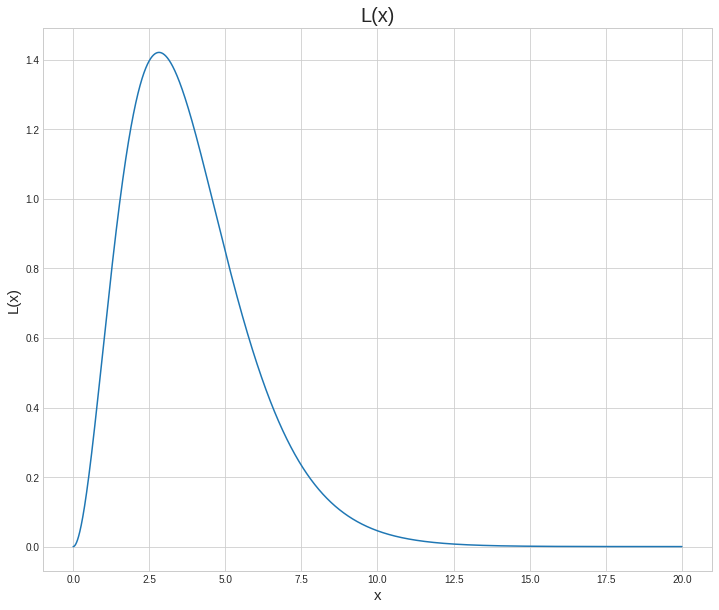

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title(f'L(x)',fontsize=20)
plt.style.use('seaborn-whitegrid') # nice and clean grid
ax.set_xlabel('x',  fontsize=15)
ax.set_ylabel('L(x)',  fontsize=15)
x = np.linspace(0.0001, 20, 10000)
ax.plot(x, L(x))

plt.show()

By this graph we see that function almost converges to 0 at around 15, so it makes perfect sence to choose upper-bound for $x$ around 15 to have 0.99 of area under original curve covered.

In [10]:
min_x = 0.00001
max_x = 16
upper_bound = np.linspace(10, max_x, 20)

for up in upper_bound:
    shortened_area = quad(L, min_x, up)[0]
    ratio = shortened_area/total_area
    if ratio>0.999:
        max_x = up
        print(f"Upperbound x={max_x} is enough to cover {ratio} of area under original curve")
        break


Upperbound x=13.157894736842106 is enough to cover 0.9991432772255174 of area under original curve


In [15]:
shortened_area = quad(L, min_x, max_x)[0]
shortened_area/total_area

0.9991432772255174

Let's normalize our function:

In [16]:
L_norm = lambda x: L(x)/shortened_area

Check that now the area under curve is approximately 1.

In [17]:
quad(L_norm, min_x, max_x)[0]

0.9999999999999998

In [18]:
crit_val = L_norm(scipy.optimize.fmin(lambda x: -L_norm(x), 1, disp=False))
crit_val

array([0.21907416])

Now, it can be assumed that this is a pdf function.

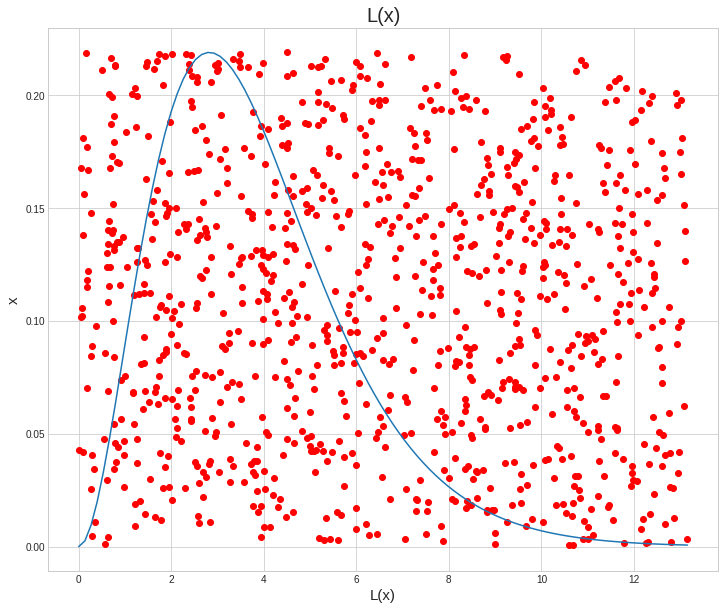

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title(f'L(x)',fontsize=20)
plt.style.use('seaborn-whitegrid') # nice and clean grid
ax.set_xlabel('L(x)',  fontsize=15)
ax.set_ylabel('x',  fontsize=15)

x = np.linspace(min_x, max_x, 100)
ax.plot(x, L_norm(x))

uni_x = np.random.uniform(min_x, max_x, 1000)
prop_uni = stats.uniform(min_x, max_x)
K = crit_val/prop_uni.pdf(uni_x[0])

samples = np.random.uniform(min_x, prop_uni.pdf(uni_x)*K)
ax.scatter(uni_x, samples, color="red") 

plt.show()

##Generating a high quality histogram from low order data

###Generator function

In [2]:
def function_generator(N, seed, validation=False):

    np.random.seed(seed)
    prop_uni = stats.uniform(min_x, max_x)

    #I need to identify scaling factor, so I need a maximum value of L(x)
    x = np.random.uniform(min_x, max_x)
    K = crit_val/prop_uni.pdf(x)
    
    counter = 0
    
    #Expected acception rate is a ratio of areas under planck curve and 
    #are covered by uniform distribution
    #it will converge to experimental accception rate with increrasing number of samples
    uni_area = crit_val * (max_x - min_x)
    expected_rate = 1/uni_area
    
    #we need N samples, so search until found N acceptable samples
    generated = []

    while len(generated) < N:
        x = np.random.uniform(min_x, max_x)
        u = np.random.uniform(min_x, K*prop_uni.pdf(x))
        val = L_norm(x)
        if u<=val:
            generated.append(x)
            
            if validation and len(generated)%10000==0:
                print(f"Finished generating {len(generated)} samples")
        
        counter+=1
      
    acception_rate = len(generated)/counter

    if validation:

        print(f"----------------\nGenerated {len(generated)} samples\nExpected acception rate: {expected_rate},\nExperimental acception rate:{acception_rate}\n----------------")

    return np.array(generated), expected_rate, acception_rate


Now, lets produce a low statistic histogram and high statistic histogram to see the data we work with. I will fix the seed of generator to some random number. 

In [25]:
seed = np.random.randint(0, 1000)
generated_samples_high  = function_generator(10000, seed, True)[0]
generated_samples_low = function_generator(300, seed, True)[0]

Finished generating 10000 samples
----------------
Generated 10000 samples
Expected acception rate: [0.34691476],
Experimental acception rate:0.34282971647982446
----------------
----------------
Generated 300 samples
Expected acception rate: [0.34691476],
Experimental acception rate:0.3215434083601286
----------------


Generate true value of normalized function as a reference:

In [26]:
def plot_histogram(num_bins, data):

    #get original data
    true_samples = np.linspace(min_x, max_x, 1000)
    true_samples_L = L_norm(true_samples)

    #graph settings
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(f'Probability distribution',fontsize=20)
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    ax.set_xlabel('x',  fontsize=15)
    ax.set_ylabel(f'Probability',  fontsize=15)

    n_low, bins_low, patches_low = ax.hist(data, bins = num_bins, facecolor = '#F57763', edgecolor='#DE734E', linewidth=0.5,  label=f"Generated v with N={len(data)}", density=True)
    ax.plot(true_samples, true_samples_L, label=f"Target function", color="blue")
    ax.legend()
    plt.show()


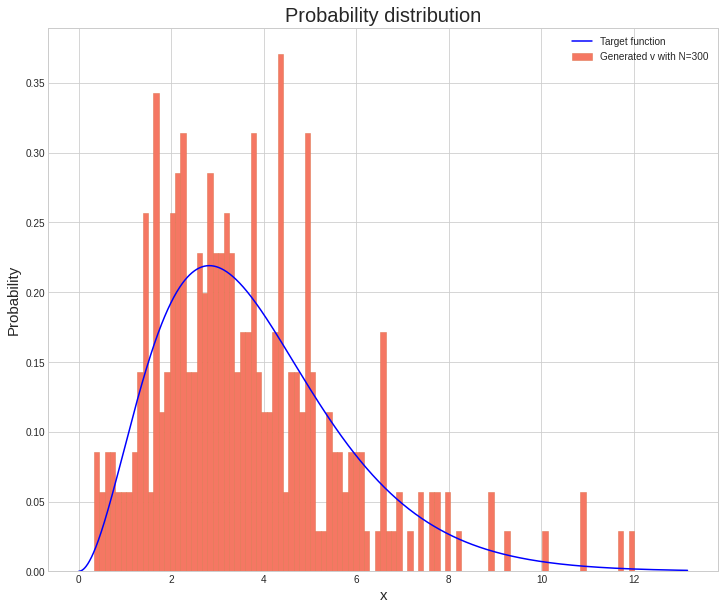

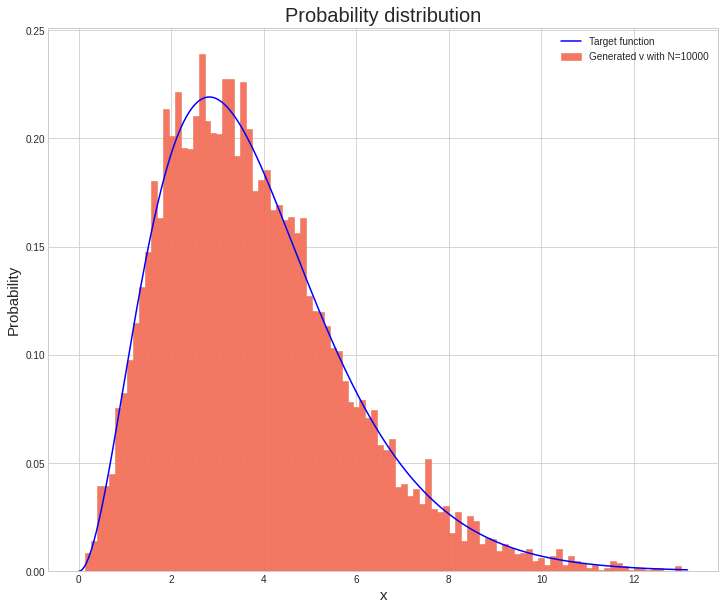

In [27]:
num_bins = 100
plot_histogram(num_bins, generated_samples_low)
plot_histogram(num_bins, generated_samples_high)

###Generating Dataset

The input will be a histogram of a low statistic (the number of samples per histogram of low statistic will be chosen randomly in some specified range). The output will be a histogram with some fixed number of samples (later on, I will experiment with varying this number).

At first I will generate input and output data, then I will split this dataset into train and test datasets in ration 80/20 (typical ratio).

In [28]:
#generate input and output data
def generate_dataset_histogram(dataset_size, num_bins, output_size, test = False):

    input = []
    output = []
    input_size = 100

    for i in range(dataset_size):

        #to fix seed at each record
        seed = np.random.randint(0, 1000)
        #randomly choose number of sample
        input_size = np.random.randint(50, 500)

        print(f"Started generating record #{i+1} with seed={seed} and N={input_size} for input samples")

        inp_data = function_generator(input_size, seed)[0]
        input.append(np.histogram(inp_data, bins=num_bins, density=True)[0])
        
        if not test:
            out_data = function_generator(output_size, seed)[0]
            output.append(np.histogram(out_data, bins=num_bins, density=True)[0])
    
    if test:
        return np.array(input), input_size
    else:
        return np.array(input), np.array(output)

In [29]:
#set parameters
dataset_size = 100
num_bins = 100
output_size = 10000

In [31]:
#generate dataset with given parameters
input_histogram, output_histogram = generate_dataset_histogram(dataset_size, num_bins, output_size)
input_histogram.shape, output_histogram.shape

Started generating record #1 with seed=916 and N=242 for input samples
Started generating record #2 with seed=102 and N=355 for input samples
Started generating record #3 with seed=298 and N=181 for input samples
Started generating record #4 with seed=539 and N=456 for input samples
Started generating record #5 with seed=83 and N=391 for input samples
Started generating record #6 with seed=118 and N=218 for input samples
Started generating record #7 with seed=826 and N=160 for input samples
Started generating record #8 with seed=174 and N=322 for input samples
Started generating record #9 with seed=149 and N=326 for input samples
Started generating record #10 with seed=336 and N=377 for input samples
Started generating record #11 with seed=40 and N=257 for input samples
Started generating record #12 with seed=616 and N=192 for input samples
Started generating record #13 with seed=661 and N=174 for input samples
Started generating record #14 with seed=548 and N=208 for input samples
Sta

((100, 100), (100, 100))

In [36]:
np.save(f'input_histogram{dataset_size}.npy', input_histogram)    # .npy extension is added if not given
np.save(f'output_histogram{dataset_size}.npy', output_histogram)

###Spliting into train and test datasets

In [37]:
inputs_histogram = torch.Tensor(np.load(f'input_histogram{dataset_size}.npy'))
outputs_histogram = torch.Tensor(np.load(f'output_histogram{dataset_size}.npy'))

In [38]:
train_X_histogram, test_X_histogram, train_y_histogram, test_y_histogram = train_test_split(inputs_histogram, outputs_histogram, test_size=0.2, random_state=42)

In [39]:
train_X_histogram.shape, test_X_histogram.shape, train_y_histogram.shape, test_y_histogram.shape

(torch.Size([80, 100]),
 torch.Size([20, 100]),
 torch.Size([80, 100]),
 torch.Size([20, 100]))

###Building a model

For denoising purposes, I have decided to use an autoencoder model that has next architecture:

<center>
<image src="https://www.assemblyai.com/blog/content/images/2022/01/autoencoder_architecture.png" width=600px>
</center>

At fisrt we need to conver our dataset (stored as numpy array) to Tensor.

Check if the gradient is turned on:

In [40]:
train_X_histogram.requires_grad 

False

In [41]:
train_X_histogram.requires_grad = True

The data is not that difficult, so the architecture of the model can be simple

In [42]:
# Model definition
class HistogramAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: affine function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)

        return out

After some trial and errors I have chosen `hidden_dim = 20` as the best parameter. I will consider changing it.

In [43]:
input_dim = inputs_histogram.shape[1]
hidden_dim = 30
output_dim = outputs_histogram.shape[1]

In [44]:
model_histogram = HistogramAutoencoder(input_dim, hidden_dim, output_dim)

In [45]:
criterion = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model_histogram.parameters(), lr=learning_rate)  

###Training a model

In future, I will need to rewrite the training procedure to train on batches. But still training is quite fast

In [30]:
def training_model_histogram(model, num_epochs):

    test_losses = []
    train_losses = []

    for epoch in range(num_epochs):

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(train_X_histogram)

        # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
        train_loss = criterion(outputs, train_y_histogram)
        train_losses.append(train_loss)

        # Getting gradients w.r.t. parameters via backpropagation
        train_loss.backward()


        # Updating parameters via gradient descent
        optimizer.step()

        test_loss = criterion(model(test_X_histogram), test_y_histogram)
        print(f"Epoch: {epoch+1}, train_loss = {train_loss}, test_loss={test_loss}")
        test_losses.append(test_loss)

    return torch.Tensor(train_losses).detach().numpy(), torch.Tensor(test_losses).detach().numpy()

Epoch: 1, train_loss = 0.18416975438594818, test_loss=0.17767532169818878
Epoch: 2, train_loss = 0.17754022777080536, test_loss=0.16902057826519012
Epoch: 3, train_loss = 0.1688748002052307, test_loss=0.15700790286064148
Epoch: 4, train_loss = 0.1569272130727768, test_loss=0.14193637669086456
Epoch: 5, train_loss = 0.141891211271286, test_loss=0.12437800318002701
Epoch: 6, train_loss = 0.12436645478010178, test_loss=0.10517165809869766
Epoch: 7, train_loss = 0.1051904484629631, test_loss=0.08539396524429321
Epoch: 8, train_loss = 0.0854392945766449, test_loss=0.06627580523490906
Epoch: 9, train_loss = 0.0663428008556366, test_loss=0.04902837425470352
Epoch: 10, train_loss = 0.049110379070043564, test_loss=0.034608203917741776
Epoch: 11, train_loss = 0.034696679562330246, test_loss=0.023508941754698753
Epoch: 12, train_loss = 0.023594669997692108, test_loss=0.01568717323243618
Epoch: 13, train_loss = 0.015762273222208023, test_loss=0.010667078197002411
Epoch: 14, train_loss = 0.01072666

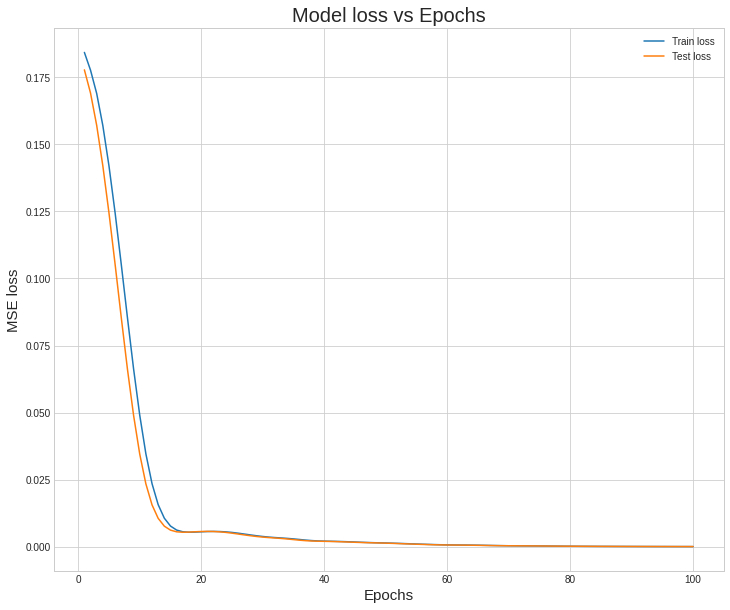

In [47]:
train_losses_histogram, test_losses_histogram = training_model_histogram(model_histogram, 100)
x = np.arange(1, 101)
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title(f'Model loss vs Epochs',fontsize=20)
plt.style.use('seaborn-whitegrid') # nice and clean grid
ax.set_xlabel('Epochs',  fontsize=15)
ax.set_ylabel(f'MSE loss',  fontsize=15)
ax.plot(x, train_losses_histogram, label="Train loss")
ax.plot(x, test_losses_histogram, label="Test loss")
ax.legend()
plt.show()

###Testing a model


In [48]:
prediction_histogram = model_histogram(test_X_histogram)
loss_histogram = criterion(prediction_histogram, test_y_histogram)
print(f"Mse on a test set: {loss_histogram}")

Mse on a test set: 0.00015640999481547624


###Produce a high order statistic from low order statistic

Started generating record #1 with seed=597 and N=52 for input samples


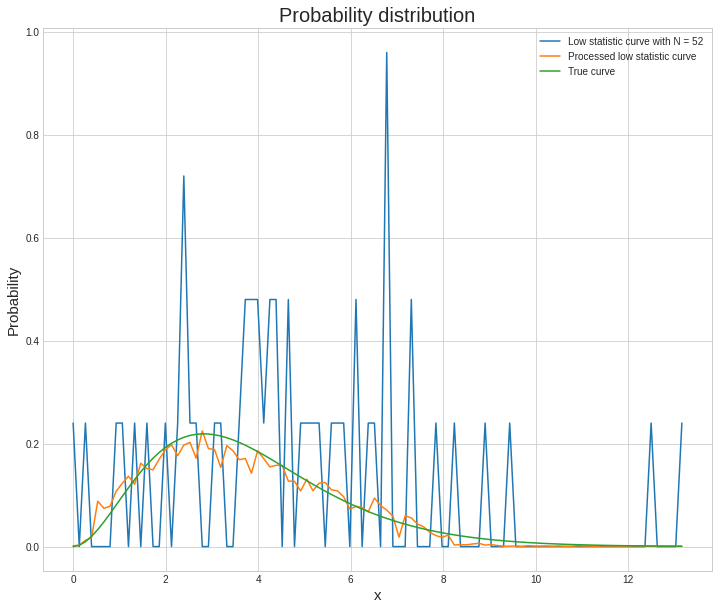

In [49]:
#generate data
sample_input, input_size = generate_dataset_histogram(1, num_bins, output_size, test=True)
processed_sample_input = model_histogram(torch.Tensor(sample_input)).detach().numpy().reshape(-1,1)
sample_input = sample_input.reshape(-1,1)

#generate true data
v = np.linspace(min_x, max_x, num_bins).reshape(-1, 1)
true = L_norm(v)

#graph settings
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title(f'Probability distribution',fontsize=20)
plt.style.use('seaborn-whitegrid') # nice and clean grid
ax.set_xlabel('x',  fontsize=15)
ax.set_ylabel(f'Probability',  fontsize=15)

ax.plot(v, sample_input, label = f"Low statistic curve with N = {input_size}")
ax.plot(v, processed_sample_input, label = f"Processed low statistic curve")
ax.plot(v, true, label="True curve")

ax.legend()
plt.show()

###Save model

In [50]:
#create folder for storing models
folder = "models"
if not os.path.exists(folder):
     os.makedirs(folder)

model_name = f"model_mse_{loss_histogram}.pth"
PATH = os.path.join(folder, model_name)

#save trained model
torch.save(model_histogram.state_dict(), PATH)

In [ ]:
#load trained model
model_histogram = HistogramAutoencoder(input_dim, hidden_dim, output_dim)
model_histogram.load_state_dict(torch.load(PATH))
model_histogram.eval()

FullyConnectedAutoencoder(
  (fc1): Linear(in_features=100, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=100, bias=True)
)

##Generate large dataset of numbers directly

With autoencoders, we indeed can denoise a low order hystogram to get a result similar to a hystogram generated with high order data. But in practice, we are not interested in generating this histogram, we would like the original samples instead. In this section, we will have two datasets: inputs and outputs (low and high order data). But we won't deal with histgram bins, but with samples instead.

At first I will generated to datasets $x$ and $X$. The size (`input_size`) of $x$ will be $100$ and the size (`ouput_size`) of $X$ will be $10000$. 

In [6]:
input_size = 200
output_size = 5000
dataset_size = 500

In [5]:
def wrapper(size, seed, lim, i):
    if (i+1)%lim == 0:
        print(f"Generated {i+1} samples")
     
    return function_generator(size, seed)[0]

In [4]:
#generate input and output data
def generate_dataset_samples(dataset_size, input_size, output_size, test = False):

    seed = np.random.randint(0, 100000, dataset_size)
    print("----------------\nStarted generating input dataset\n----------------")
    input = np.array([wrapper(input_size, s, 50, i) for i, s in enumerate(seed)])
    
    if test:
        return input
    else:
        print("----------------\nStarted generating output dataset\n----------------")
        output = np.array([wrapper(output_size, s, 10, i) for i, s in enumerate(seed)])
        
        return input, output

In [19]:
input_samples, output_samples = generate_dataset_samples(dataset_size, input_size, output_size)

----------------
Started generating input dataset
----------------
Generated 50 samples
Generated 100 samples
Generated 150 samples
Generated 200 samples
Generated 250 samples
Generated 300 samples
Generated 350 samples
Generated 400 samples
Generated 450 samples
Generated 500 samples
----------------
Started generating output dataset
----------------
Generated 10 samples
Generated 20 samples
Generated 30 samples
Generated 40 samples
Generated 50 samples
Generated 60 samples
Generated 70 samples
Generated 80 samples
Generated 90 samples
Generated 100 samples
Generated 110 samples
Generated 120 samples
Generated 130 samples
Generated 140 samples
Generated 150 samples
Generated 160 samples
Generated 170 samples
Generated 180 samples
Generated 190 samples
Generated 200 samples
Generated 210 samples
Generated 220 samples
Generated 230 samples
Generated 240 samples
Generated 250 samples
Generated 260 samples
Generated 270 samples
Generated 280 samples
Generated 290 samples
Generated 300 sam

In [20]:
np.save(f'input_samples_{dataset_size}.npy', input_samples)    # .npy extension is added if not given
np.save(f'output_samples_{dataset_size}.npy', output_samples)

###Splitting to test/train data

In [21]:
inputs_samples = torch.Tensor(np.load(f'input_samples_{dataset_size}.npy'))
outputs_samples = torch.Tensor(np.load(f'output_samples_{dataset_size}.npy'))
full_dataset = TensorDataset(inputs_samples, outputs_samples)

In [22]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

###Data Loader

In [23]:
# Batch size, iterations and epochs
batch_size = 50
n_iters = 250
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

###Bulding a model

In [78]:
# Model definition
class SamplesAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):

        super().__init__()
        
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)

        
        # Decoder: affine function
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc4 = nn.Linear(hidden_dim_1, output_dim)
        

    def forward(self, x):
        # Encoder: affine function
        
        out = self.fc1(x) 
        out = F.leaky_relu(out) 
        out = self.fc2(out)
        out = F.leaky_relu(out) 
        out = self.fc3(out)
        out = F.leaky_relu(out) 
        out = self.fc4(out)


        return out
        

In [79]:
hidden_dim_1 = 150
hidden_dim_2 = 50

In [84]:
model_samples = SamplesAutoencoder(input_size, hidden_dim_1, hidden_dim_2, output_size)

In [85]:
model_samples

SamplesAutoencoder(
  (fc1): Linear(in_features=200, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=5000, bias=True)
)

In [86]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model_samples.parameters(), lr=learning_rate)  

###Training a model

In [31]:
def training_model_samples(train_loader, test_loader, model, num_epochs):

    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):

        total_train_loss = 0
        total_test_loss = 0

        train_num_samples = 0
        test_num_samples = 0

        for i, (X_train, y_train) in enumerate(train_loader):
            # Load images with gradient accumulation capabilities
            X_train = X_train.requires_grad_()

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output
            outputs = model(X_train)

            # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
            loss = criterion(outputs, y_train)
            total_train_loss += loss
            train_num_samples +=1

            # Getting gradients w.r.t. parameters via backpropagation
            loss.backward()

            # Updating parameters via gradient descent
            optimizer.step()

        train_loss.append(total_train_loss/train_num_samples)

        for X_test, y_test in test_loader:
            # Forward pass only to get logits/output
            outputs = model(X_test)


            # Total test loss
            total_test_loss += criterion(outputs, y_test)
            test_num_samples += 1

        mean_test_loss = total_test_loss / test_num_samples
        test_loss.append(mean_test_loss)

        # Print Loss
        print(f'Epoch: {epoch+1}. Average Test Loss: {test_loss[-1]}.')
        
    return  torch.Tensor(train_loss).detach().numpy(), torch.Tensor(test_loss).detach().numpy()

Epoch: 1. Average Test Loss: 16.61093521118164.
Epoch: 2. Average Test Loss: 11.8634033203125.
Epoch: 3. Average Test Loss: 7.86610221862793.
Epoch: 4. Average Test Loss: 5.566050052642822.
Epoch: 5. Average Test Loss: 4.640168190002441.
Epoch: 6. Average Test Loss: 4.300403594970703.
Epoch: 7. Average Test Loss: 4.169467926025391.
Epoch: 8. Average Test Loss: 4.112344741821289.
Epoch: 9. Average Test Loss: 4.093059539794922.
Epoch: 10. Average Test Loss: 4.084741592407227.
Epoch: 11. Average Test Loss: 4.085268497467041.
Epoch: 12. Average Test Loss: 4.078515529632568.
Epoch: 13. Average Test Loss: 4.076429843902588.
Epoch: 14. Average Test Loss: 4.0762834548950195.
Epoch: 15. Average Test Loss: 4.077141284942627.
Epoch: 16. Average Test Loss: 4.077668190002441.
Epoch: 17. Average Test Loss: 4.0753326416015625.
Epoch: 18. Average Test Loss: 4.079133987426758.
Epoch: 19. Average Test Loss: 4.076661586761475.
Epoch: 20. Average Test Loss: 4.073380470275879.
Epoch: 21. Average Test Loss:

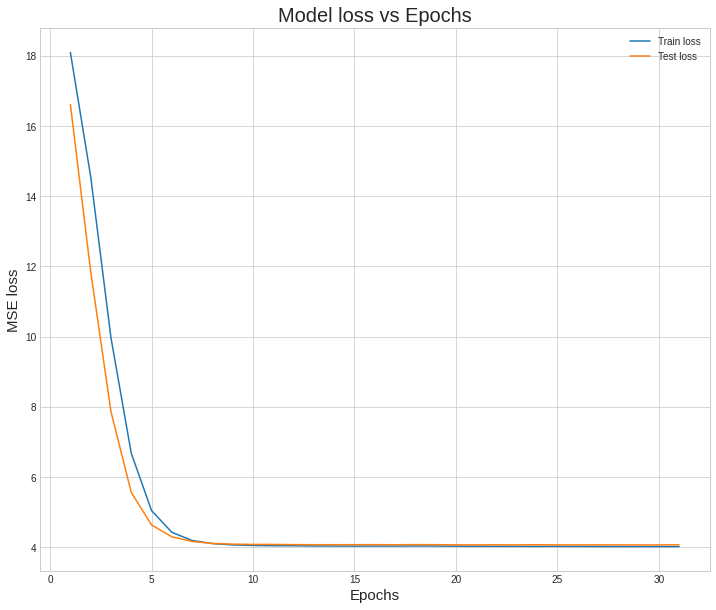

In [88]:
train_loss, test_loss = training_model_samples(train_loader, test_loader, model_samples, num_epochs)

x = np.arange(1, num_epochs+1)
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title(f'Model loss vs Epochs',fontsize=20)
plt.style.use('seaborn-whitegrid') # nice and clean grid
ax.set_xlabel('Epochs',  fontsize=15)
ax.set_ylabel(f'MSE loss',  fontsize=15)
ax.plot(x, train_loss, label="Train loss")
ax.plot(x, test_loss, label="Test loss")
ax.legend()
plt.show()

----------------
Started generating input dataset
----------------


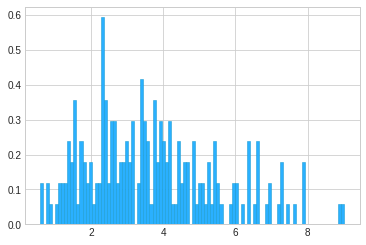

In [89]:
#generate data
sample_input = generate_dataset_samples(1, input_size, output_size, True)
processed_sample_input = model_samples(torch.Tensor(sample_input)).detach().numpy().reshape(-1,1)
sample_input = sample_input.reshape(-1,1)
plt.hist(sample_input, bins = 100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5,  label="Generated v", density=True)
plt.show()

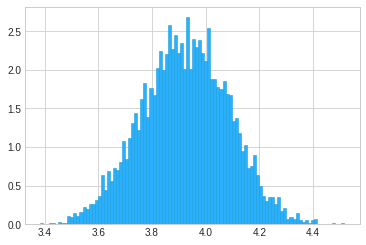

In [90]:
plt.hist(processed_sample_input, bins = 100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5,  label="Generated v", density=True)
plt.show()

Probably it is impossible to accoplish the task using autoencoders when the data is random. Autoencoder will succeed when the particles are sorted within input and output samples, but then unneccessary properties will arrise.

##Approach 2 – Variational autoencoder for generating new data

Simple autoencoder doesn't perform well with stochastic data. In the previous section, I have shown that sorting Monte Carlo data in our case leaded to a successefull predicition of a true distribution. But usually sorting stohastic data leads to unwanted properties. So, it was decided to extend existing autoencoder to VAE.

In [36]:
device = torch.device("cuda")
device

device(type='cuda')

In [55]:
# Model definition
class SamplesVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):

        super().__init__()
        
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)

        self.z_mean = nn.Linear(hidden_dim_2, 2)
        self.z_log_var = nn.Linear(hidden_dim_2, 2)

        
        # Decoder: affine function
        self.fc3 = nn.Linear(2, hidden_dim_2)
        self.fc4 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc5 = nn.Linear(hidden_dim_1, output_dim)

    def reparameterize(self, z_mu, z_log_var):

        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2)
        return z

    def forward(self, x):
        # Encoder
        out = self.fc1(x) 
        out = F.leaky_relu(out) 
        out = self.fc2(out) 
        out = F.leaky_relu(out) 

        z_mean, z_log_var = self.z_mean(out), self.z_log_var(out)
        out = self.reparameterize(z_mean, z_log_var)

        #Decoder
        out = self.fc3(out)
        out = F.leaky_relu(out) 
        out = self.fc4(out)
        out = F.leaky_relu(out) 
        out = self.fc5(out)


        return out
        

In [56]:
# Batch size, iterations and epochs
batch_size = 50
n_iters = 250
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [57]:
hidden_dim_1 = 150
hidden_dim_2 = 50
model_samples_vae = SamplesVAE(input_size, hidden_dim_1, hidden_dim_2, output_size)
model_samples_vae

SamplesVAE(
  (fc1): Linear(in_features=200, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=50, bias=True)
  (z_mean): Linear(in_features=50, out_features=2, bias=True)
  (z_log_var): Linear(in_features=50, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=150, bias=True)
  (fc5): Linear(in_features=150, out_features=5000, bias=True)
)

In [58]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model_samples_vae.parameters(), lr=learning_rate)  

In [59]:
train_loss, test_loss = training_model_samples(train_loader, test_loader, model_samples_vae, num_epochs)

Epoch: 1. Average Test Loss: 12.910655975341797.
Epoch: 2. Average Test Loss: 5.478726387023926.
Epoch: 3. Average Test Loss: 4.377490997314453.
Epoch: 4. Average Test Loss: 4.288110733032227.
Epoch: 5. Average Test Loss: 4.1458740234375.
Epoch: 6. Average Test Loss: 4.118712425231934.
Epoch: 7. Average Test Loss: 4.090954780578613.
Epoch: 8. Average Test Loss: 4.071154594421387.
Epoch: 9. Average Test Loss: 4.067297458648682.
Epoch: 10. Average Test Loss: 4.066784858703613.
Epoch: 11. Average Test Loss: 4.065882205963135.
Epoch: 12. Average Test Loss: 4.064388751983643.
Epoch: 13. Average Test Loss: 4.065807819366455.
Epoch: 14. Average Test Loss: 4.065361976623535.
Epoch: 15. Average Test Loss: 4.065084457397461.
Epoch: 16. Average Test Loss: 4.064064979553223.
Epoch: 17. Average Test Loss: 4.065422058105469.
Epoch: 18. Average Test Loss: 4.06500768661499.
Epoch: 19. Average Test Loss: 4.065204620361328.
Epoch: 20. Average Test Loss: 4.067523956298828.
Epoch: 21. Average Test Loss: 4

----------------
Started generating input dataset
----------------


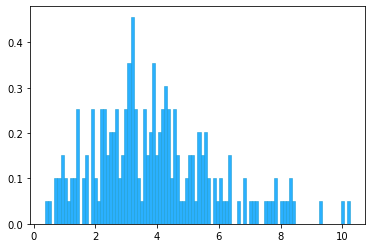

In [62]:
#generate data
sample_input = generate_dataset_samples(1, input_size, output_size, True)
processed_sample_input = model_samples_vae(torch.Tensor(sample_input)).detach().numpy().reshape(-1,1)
sample_input = sample_input.reshape(-1,1)
plt.hist(sample_input, bins = 100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5,  label="Generated v", density=True)
plt.show()

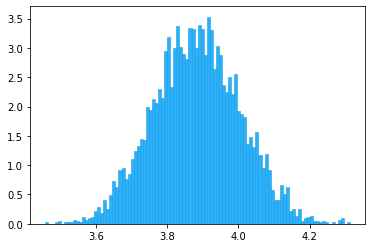

In [63]:
plt.hist(processed_sample_input, bins = 100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5,  label="Generated v", density=True)
plt.show()

Maybe I have some problems with understanding how varietional encoders work, so I will return to this task later on after literature review. 